In [1]:
import pyspark
from pyspark.context import SparkContext, SparkConf
from pyspark.sql.session import SparkSession


In [2]:
import pyspark.sql.functions as f
import pyspark.sql.functions

In [3]:
spark = (
    SparkSession
    .builder
    .appName('BIT_01')
    .config('spark.ui.port', '9311')
    .config('spark.executor.memoryOverhead', '1G')
    .config('spark.shuffle.service.enabled', 'true')
    .config('spark.dynamicAllocation.enabled', 'true')
    .getOrCreate()
)

In [4]:
spark

In [5]:
df = spark.read.json('npl_news.json')

In [6]:
df.show(10)

+---------------+-------------+----------+--------------------+--------------------+--------------------+
|        authors|     category|      date|            headline|                link|   short_description|
+---------------+-------------+----------+--------------------+--------------------+--------------------+
|Melissa Jeltsen|        CRIME|2018-05-26|There Were 2 Mass...|https://www.huffi...|She left her husb...|
|  Andy McDonald|ENTERTAINMENT|2018-05-26|Will Smith Joins ...|https://www.huffi...|Of course it has ...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Hugh Grant Marrie...|https://www.huffi...|The actor and his...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Jim Carrey Blasts...|https://www.huffi...|The actor gives D...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Julianna Margulie...|https://www.huffi...|The "Dietland" ac...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Morgan Freeman 'D...|https://www.huffi...|"It is not right ...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Dona

In [7]:
df = df.distinct().na.drop("all")
df.count()

124986

In [8]:
df.select('authors').distinct().show(10,False)

+----------------------------------------------------------------------+
|authors                                                               |
+----------------------------------------------------------------------+
|Zach Carter, Arthur Delaney, and Igor Bobic                           |
|Maxwell Strachan                                                      |
|Steve Holland, Reuters                                                |
|Lisa Rapaport, Reuters                                                |
|Andy Campbell, Nick Visser, and Antonia Blumberg                      |
|Antonia Blumberg and Jesselyn Cook                                    |
|Oliver Balch, On assignment for HuffPost                              |
|Carol J. Clouse, On Assignment For HuffPost                           |
|Steven Rosenbaum  , ContributorTechnologist / Business Leader / Author|
|Chris Jordan, ContributorArtist, photographer and director.           |
+--------------------------------------------------

### 1. Какие авторы и сколько раз встречались в общем пуле данных (1 автор - количество повторений)

In [9]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover

In [10]:
regexTokenizer_ = RegexTokenizer(inputCol='authors', outputCol='authors_token', pattern=r"[,]|and")
regexTokenized_ = regexTokenizer_.transform(df).select('authors_token')
remover_ = StopWordsRemover(inputCol='authors_token', outputCol="authors_filtered")
remover__ = remover_.transform(regexTokenized_).select('authors_filtered')
remover__.show(10,False)

+-----------------------------------------------------+
|authors_filtered                                     |
+-----------------------------------------------------+
|[ron dicker]                                         |
|[matthew jacobs]                                     |
|[lee moran]                                          |
|[sebastian murdock,  carla herreria,  ,  doha madani]|
|[akbar shahid ahmed]                                 |
|[sara boboltz]                                       |
|[carol kuruvilla]                                    |
|[hayley miller]                                      |
|[eliot nelson]                                       |
|[ed mazza]                                           |
+-----------------------------------------------------+
only showing top 10 rows



In [11]:
#### Нужна очистка от всяких лишних слов и ссылок, от профессии и тп... 
#### Пока остановилась на том, что разделила по регурке нескольких авторов

In [12]:
author_count = remover__ \
    .withColumn('author_one', f.explode(f.col('authors_filtered'))) \
    .filter(f.col('author_one') != " ") \
    .groupBy('author_one') \
    .count().alias('count') \
    .orderBy(f.desc('count')) 
author_count = author_count.filter(~f.col('author_one').rlike('contributor*')) # исключение всяких contributor

author_count.show(10,False)

+-----------------+-----+
|author_one       |count|
+-----------------+-----+
| reuters         |3381 |
|lee moran        |2424 |
|ron dicker       |1802 |
|ed mazza         |1321 |
|cole delbyck     |1141 |
|y mcdonald       |1070 |
|julia brucculieri|1059 |
|carly ledbetter  |1024 |
|curtis m. wong   |1005 |
|mary papenfuss   |974  |
+-----------------+-----+
only showing top 10 rows



In [13]:
df.filter(f.lower(df.authors) == 'carly ledbetter').show(5)

+---------------+-------------+----------+--------------------+--------------------+--------------------+
|        authors|     category|      date|            headline|                link|   short_description|
+---------------+-------------+----------+--------------------+--------------------+--------------------+
|Carly Ledbetter|ENTERTAINMENT|2018-01-29|Chrissy Teigen An...|https://www.huffi...|    Congratulations!|
|Carly Ledbetter|ENTERTAINMENT|2018-01-15|CBS Asked Sharon ...|https://www.huffi...|"Can you imagine ...|
|Carly Ledbetter|ENTERTAINMENT|2018-04-19|Carrie Underwood ...|https://www.huffi...|She spoke publicl...|
|Carly Ledbetter|ENTERTAINMENT|2018-01-26|Elton John Reveal...|https://www.huffi...|           Too cute!|
|Carly Ledbetter|ENTERTAINMENT|2018-02-05|Justin Timberlake...|https://www.huffi...|He brought down t...|
+---------------+-------------+----------+--------------------+--------------------+--------------------+
only showing top 5 rows



### 2. Статистика по категориям (сколько новостей в каждой категории)

In [14]:
df_category = df.groupBy('category').count().orderBy(f.desc('count')) 
df_category.show(20,False)

+--------------+-----+
|category      |count|
+--------------+-----+
|POLITICS      |32738|
|ENTERTAINMENT |14257|
|HEALTHY LIVING|6694 |
|QUEER VOICES  |4995 |
|BUSINESS      |4254 |
|SPORTS        |4167 |
|COMEDY        |3971 |
|PARENTS       |3955 |
|BLACK VOICES  |3858 |
|THE WORLDPOST |3664 |
|WOMEN         |3489 |
|CRIME         |2893 |
|MEDIA         |2815 |
|WEIRD NEWS    |2670 |
|GREEN         |2622 |
|IMPACT        |2602 |
|WORLDPOST     |2579 |
|RELIGION      |2556 |
|STYLE         |2254 |
|WORLD NEWS    |2177 |
+--------------+-----+
only showing top 20 rows



### 3. Показать наиболее часто встречающиеся слова в ['headline']

In [15]:
df_headline = df.withColumn('headline', f.lower(f.col('headline')))

In [16]:
df_headline.show(10)

+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|             authors|     category|      date|            headline|                link|   short_description|
+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|          Ron Dicker|       SPORTS|2018-05-23|nfl bans kneeling...|https://www.huffi...|Teams can set the...|
|      Matthew Jacobs|ENTERTAINMENT|2018-04-28|all the movies th...|https://www.huffi...|Whether you're lo...|
|           Lee Moran|   WEIRD NEWS|2018-04-27|pets are 'the 1 p...|https://www.huffi...|The 25 most profo...|
|Sebastian Murdock...|        CRIME|2018-04-24|dallas officer sh...|https://www.huffi...|Officer Rogelio S...|
|  Akbar Shahid Ahmed|     POLITICS|2018-04-18|top gop senator h...|https://www.huffi...|Senate Foreign Re...|
|        Sara Boboltz| BLACK VOICES|2018-04-13|cal poly presiden...|https://www.huffi...|The student said ...|
|

In [17]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover

In [18]:
regexTokenizer = RegexTokenizer(inputCol='headline', outputCol='headline_token', pattern=r"[,\s]")
regexTokenized = regexTokenizer.transform(df_headline).select('headline_token')

remover = StopWordsRemover(inputCol='headline_token', outputCol="headline_filtered")
remover_ = remover.transform(regexTokenized).select('headline_filtered')
remover_.show(10,False)

+--------------------------------------------------------------------------------+
|headline_filtered                                                               |
+--------------------------------------------------------------------------------+
|[nfl, bans, kneeling, national, anthem]                                         |
|[movies, cool, summer]                                                          |
|[pets, 'the, 1, percent', animals]                                              |
|[dallas, officer, shot, home, depot, dies., 2, others, still, hospital.]        |
|[top, gop, senator, hopes, macron, merkel, convince, trump, save, iran, deal]   |
|[cal, poly, president, says, frat, member, blackface, likely, expelled]         |
|[british, muslims, vigilant, defiant, 'punish, muslim', day]                    |
|[officer, charged, murder, shooting, death, justine, damond]                    |
|[friday's, morning, email:, trump, kim, jong, un, meet]                         |
|[wa

In [19]:
word_count = remover_ \
    .withColumn('word', f.explode(f.col('headline_filtered'))) \
    .groupBy('word') \
    .count().alias('count') \
    .orderBy(f.desc('count')) 
    
word_count.show(10)

+-------+-----+
|   word|count|
+-------+-----+
|  trump| 9061|
|    new| 5481|
| donald| 4551|
|   says| 3132|
|trump's| 2565|
|   u.s.| 2192|
|  women| 2097|
| people| 1974|
|  first| 1866|
|    one| 1832|
+-------+-----+
only showing top 10 rows



### 4. Универсальная функция для построения гистограмм для наглядных ответов на вопросы выше

In [20]:
import matplotlib.pyplot as plt

In [21]:
def hist(df, max_count):
    plt.figure(figsize=(20, 16))
    plt.rcParams.update({'font.size': 10}) 
    df_hist = df.toPandas()
    df_hist = df_hist.head(max_count)
    plt.bar(df_hist[df_hist.columns[0]], df_hist[df_hist.columns[1]])
    plt.xlabel("Данные", fontsize=18)
    plt.xticks(rotation=45)
    plt.ylabel("Количество", fontsize=18)
    plt.show()

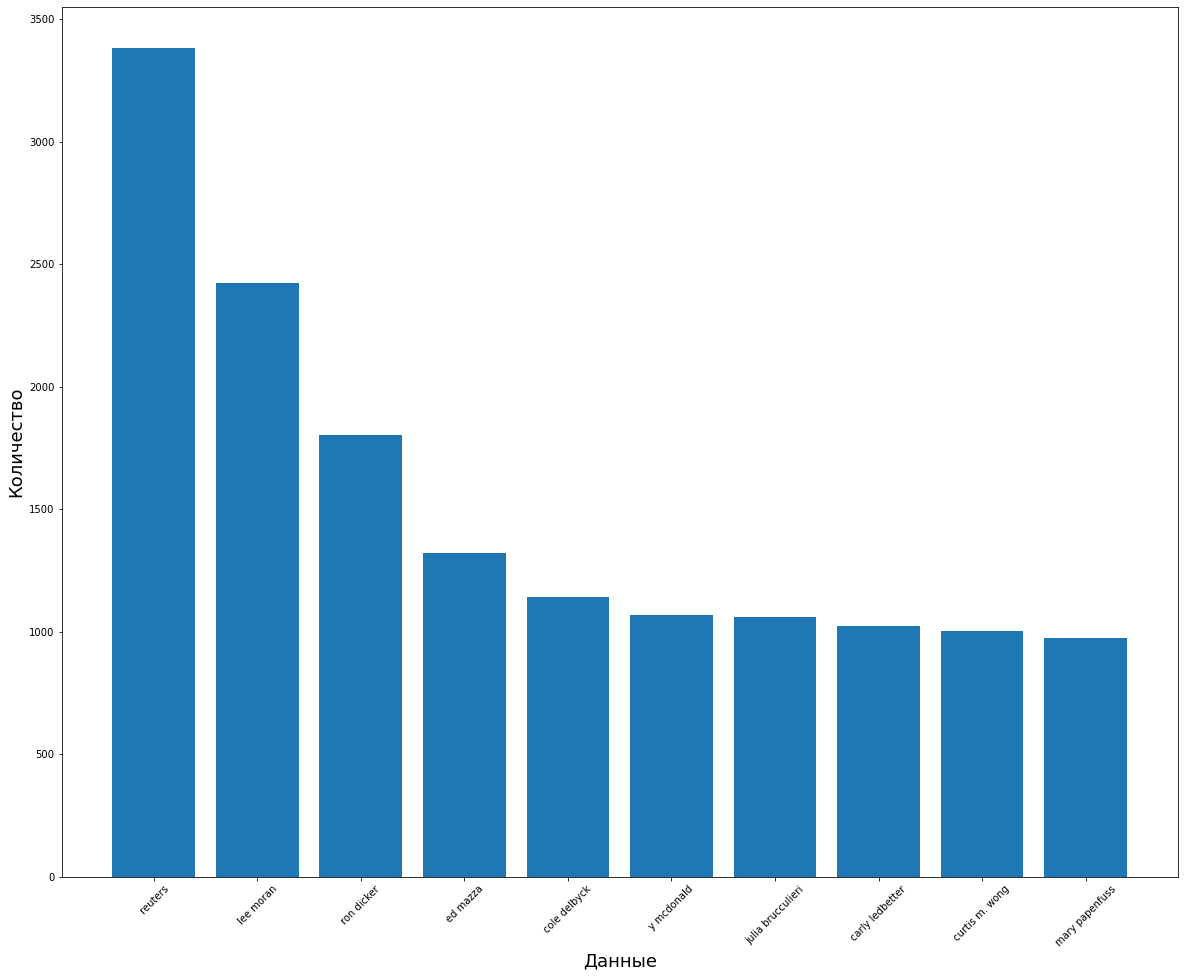

In [22]:
hist(author_count, 10)

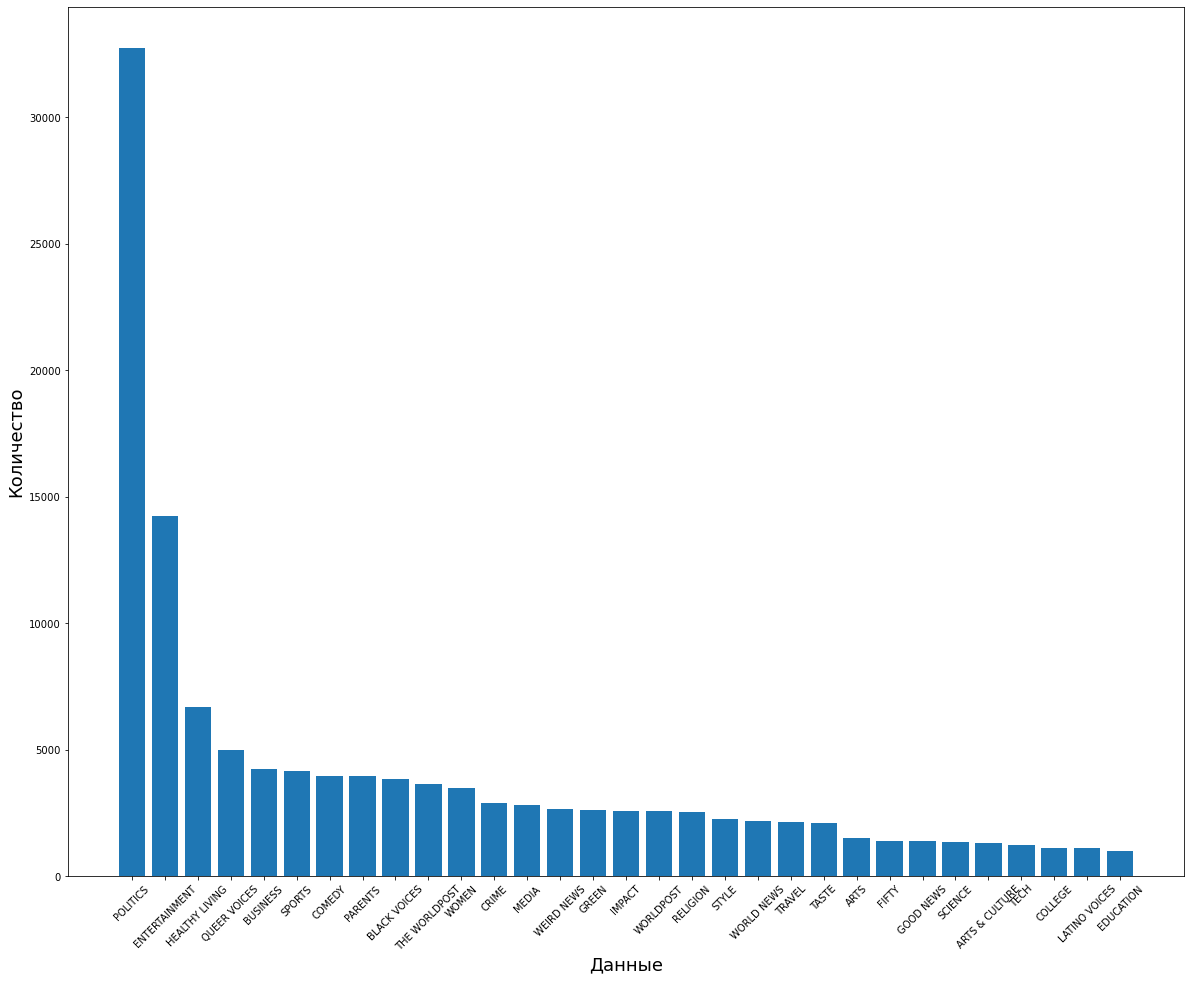

In [23]:
hist(df_category, 50)

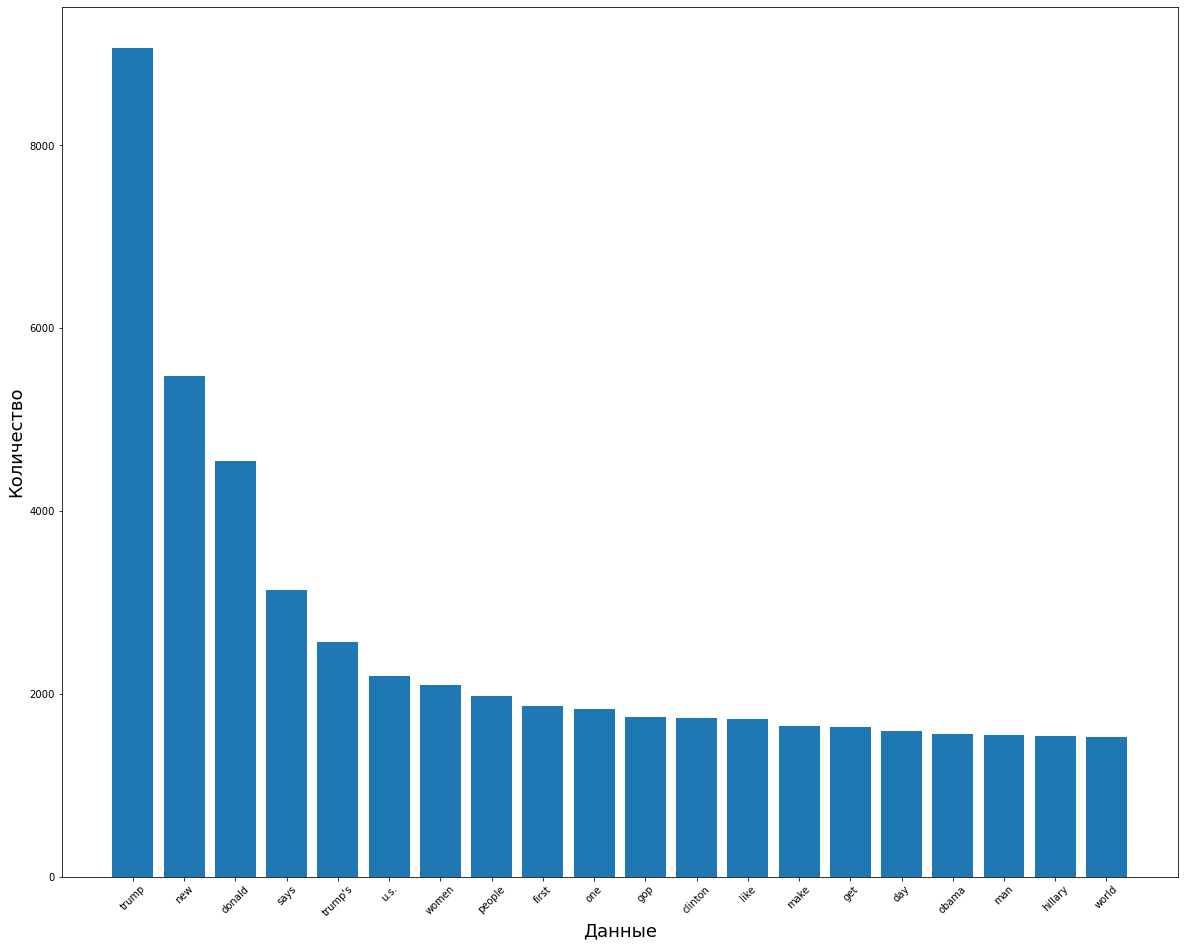

In [24]:
hist(word_count, 20)

### 5. В какой год было больше новостей про Россию?

In [25]:
df_russia = df.withColumn('headline', f.lower(f.col('headline')))
df_russia = df_russia.withColumn('short_description', f.lower(f.col('short_description')))

In [26]:
df_russia_cnt = df_russia.filter(f.col('headline').like('%russia%') | \
                 f.col('headline').like('%putin%') | \
                 f.col('headline').like('%moscow%') | \
                 f.col('headline').like('%petersburg%') | \
                 f.col('short_description').like('%russia%') | \
                 f.col('short_description').like('%putin%') | \
                 f.col('short_description').like('%moscow%') | \
                 f.col('short_description').like('%petersburg%') | \
                 f.col('link').like('%russia%') | \
                 f.col('link').like('%putin%') | \
                 f.col('link').like('%moscow%') | \
                 f.col('link').like('%petersburg%'))

In [27]:
df_russia_cnt.show(1)

+--------------+--------+----------+--------------------+--------------------+--------------------+
|       authors|category|      date|            headline|                link|   short_description|
+--------------+--------+----------+--------------------+--------------------+--------------------+
|Ryan J. Reilly|POLITICS|2017-12-07|paul manafort's l...|https://www.huffi...|a lawyer for the ...|
+--------------+--------+----------+--------------------+--------------------+--------------------+
only showing top 1 row



In [28]:
df_russia_cnt = df_russia_cnt.withColumn('year', df_russia_cnt['date'].substr(1,4))
df_russia_cnt.show(10)

+--------------------+----------+----------+--------------------+--------------------+--------------------+----+
|             authors|  category|      date|            headline|                link|   short_description|year|
+--------------------+----------+----------+--------------------+--------------------+--------------------+----+
|      Ryan J. Reilly|  POLITICS|2017-12-07|paul manafort's l...|https://www.huffi...|a lawyer for the ...|2017|
|                    |    SPORTS|2018-02-25|russian hockey pl...|https://www.huffi...|the men's team sa...|2018|
|           S.V. Date|  POLITICS|2017-12-15|‘i love wikileaks...|https://www.huffi...|trump praised the...|2017|
|            Ed Mazza|  POLITICS|2018-04-12|here's a poll tru...|https://www.huffi...|...but he did bea...|2018|
|      Mary Papenfuss|     MEDIA|2017-12-02|abc corrects expl...|https://www.huffi...|flynn was asked t...|2017|
|          Willa Frej|  POLITICS|2018-05-21|hillary clinton t...|https://www.huffi...|"if you ca

In [29]:
df_russia_cnt \
    .groupBy(df_russia_cnt.year) \
    .count() \
    .orderBy(f.desc('count')) \
    .show()

+----+-----+
|year|count|
+----+-----+
|2017|  855|
|2016|  402|
|2018|  241|
|2014|  169|
|2015|  161|
+----+-----+



### Вывод: больше всего новостей про Россию было в 2017 году. 